In [50]:
#1) take one specific function
#2) Optimize it using gradient descent (and SGD)
#3) Optimize using GA
#4) Optimize using our proposal
#5) Think about the grid thing and be more skeptical on this implementations
#6) Should I use the function itself or the samples from it - (Initially probably the function alone is fine)
#7) Perhaps the extra could be just using gaussian distributions 

In [51]:
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

In [52]:
# Define function
def model_1(x, a, b):
    x = np.array(x)
    return a * np.sum(x) + b * a -b**2*a + a**3 - b

# Quadratic model function
def model_quadratic(x, a, b):
    x = np.array(x)
    return a * np.sum(x**2) + b * np.sum(x) + a**2 - b**2 + a * b

# Exponential decay model
def model_exponential(x, a, b):
    x = np.array(x)
    return np.sum(np.exp(-a * x)) + b * np.mean(x) - a * b

# Sinusoidal model function
def model_sinusoidal(x, a, b):
    x = np.array(x)
    return a * np.sum(np.sin(b * x)) - b * np.sum(np.cos(a * x)) + a**2 - b**2

# Logarithmic model function
def model_logarithmic(x, a, b):
    x = np.array(x)
    return a * np.sum(np.log1p(np.abs(x))) + b * np.mean(x) - a * b**2

# Absolute error model function
def model_absolute(x, a, b):
    x = np.array(x)
    return a * np.sum(np.abs(x)) + b * np.median(x) + a**2 - b**2

# Complex combination model function
def model_complex(x, a, b):
    x = np.array(x)
    return np.sum(a * np.sin(b * x) + b * np.exp(-a * x) + a**2 - b**2 + np.log1p(np.abs(a * x - b)))


In [53]:
# Define the target function using the true parameters
def target_function(x, true_a, true_b, model):
    return model(x, true_a, true_b)

def found_function(x, a, b, model):
    return model(x, a, b)

In [54]:
# Functions to find local and global minima
def find_local_minima(grid, a_vals, b_vals):
    local_min_mask = grid == scipy.ndimage.minimum_filter(grid, size=3)
    return [(a_vals[i], b_vals[j]) for i, j in np.argwhere(local_min_mask)]

def find_global_minimum(grid, a_vals, b_vals):
    min_index = np.unravel_index(np.argmin(grid), grid.shape)
    return (a_vals[min_index[0]], b_vals[min_index[1]])

Generate landscape

In [55]:
def create_landscape(x_range_1D, true_a, true_b, a_values, b_values, model, epsilon):
    true_values_1D = np.array([model([x], true_a, true_b) for x in x_range_1D])

    # Compute raw error and MSE over the (a, b) grid
    error_grid = np.zeros((len(a_values), len(b_values)))
    MSE_grid = np.zeros((len(a_values), len(b_values)))

    for i, a in enumerate(a_values):
        for j, b in enumerate(b_values):
            predicted_values = np.array([model([x], a, b) for x in x_range_1D])
            error_grid[i, j] = np.mean(true_values_1D - predicted_values)  
            MSE_grid[i, j] = np.mean((true_values_1D - predicted_values) ** 2)  

    error_grid_log = np.sign(error_grid) * np.log1p(np.abs(error_grid) + epsilon)
    MSE_grid_log = np.log1p(MSE_grid + epsilon)
    
    return true_values_1D, error_grid, MSE_grid, error_grid_log, MSE_grid_log

Proposed model

In [56]:
# Function to sample two points ensuring one is positive and the other is negative in raw error
def sample_valid_pairs(error_grid, a_vals, b_vals, max_tries=10000):
    tries = 0  # Initialize attempt counter

    while tries < max_tries:
        tries += 1

        # Randomly sample two pairs of (a, b) values
        sampled_pair_1 = (random.choice(a_vals), random.choice(b_vals))
        sampled_pair_2 = (random.choice(a_vals), random.choice(b_vals))

        # Get their corresponding error values
        idx1 = (np.abs(a_vals - sampled_pair_1[0])).argmin(), (np.abs(b_vals - sampled_pair_1[1])).argmin()
        idx2 = (np.abs(a_vals - sampled_pair_2[0])).argmin(), (np.abs(b_vals - sampled_pair_2[1])).argmin()

        error_1 = error_grid[idx1]
        error_2 = error_grid[idx2]

        # Ensure one error is positive and the other is negative
        if error_1 * error_2 < 0:
            return sampled_pair_1, sampled_pair_2

    # Raise an error if no valid pairs are found within max_tries
    raise ValueError(f"Failed to find valid pairs after {max_tries} attempts.")

In [57]:
def bisection_method(error_grid, a_vals, b_vals, sampled_pair_1, sampled_pair_2, tol=1e-3, max_iter=50):
    # Get the initial sampled points
    (a_low, b_low), (a_high, b_high) = sampled_pair_1, sampled_pair_2

    for _ in range(max_iter):
        # Compute midpoint
        a_mid = (a_low + a_high) / 2
        b_mid = (b_low + b_high) / 2

        # Get error at midpoint
        idx_mid = (np.abs(a_vals - a_mid)).argmin(), (np.abs(b_vals - b_mid)).argmin()
        error_mid = error_grid[idx_mid]

        # If error is sufficiently close to zero, stop
        if abs(error_mid) < tol:
            return a_mid, b_mid

        # Update bounds based on sign of error
        idx_low = (np.abs(a_vals - a_low)).argmin(), (np.abs(b_vals - b_low)).argmin()
        error_low = error_grid[idx_low]

        if error_mid * error_low < 0:  # Zero crossing lies between (a_low, b_low) and (a_mid, b_mid)
            a_high, b_high = a_mid, b_mid
        else:  # Zero crossing lies between (a_mid, b_mid) and (a_high, b_high)
            a_low, b_low = a_mid, b_mid

    return a_mid, b_mid  # Return the best approximation

In [58]:
# Random walk to find the minimum MSE from the estimated zero-error region with tolerance
def random_walk_mse_with_path(a_start, b_start, mse_grid, error_grid, a_vals, b_vals, step_size=1, max_iter=10000, tol=10):
    a_current, b_current = a_start, b_start
    path = [(a_current, b_current)]  # Store path

    for _ in range(max_iter):
        idx_a = (np.abs(a_vals - a_current)).argmin()
        idx_b = (np.abs(b_vals - b_current)).argmin()
        mse_current = mse_grid[idx_a, idx_b]

        step_a = random.uniform(-step_size, step_size)
        step_b = random.uniform(-step_size, step_size)

        a_new, b_new = a_current + step_a, b_current + step_b
        a_new = np.clip(a_new, a_vals[0], a_vals[-1])
        b_new = np.clip(b_new, b_vals[0], b_vals[-1])

        idx_a_new = (np.abs(a_vals - a_new)).argmin()
        idx_b_new = (np.abs(b_vals - b_new)).argmin()
        mse_new = mse_grid[idx_a_new, idx_b_new]
        error_new = error_grid[idx_a_new, idx_b_new]

        # Only move if the new point has raw error within tolerance and a lower MSE
        if abs(error_new) < tol and mse_new < mse_current:
            a_current, b_current = a_new, b_new
            mse_current = mse_new
            path.append((a_current, b_current))  # Store path

    return a_current, b_current, path, mse_new


In [59]:
def proposed_optimizer(error_grid, a_values, b_values, MSE_grid, mse_tol=1e-3, max_iter=10):
    mse_current = 1000000
    a_mse_current = 0
    b_mse_current = 0
    for iteration in range(max_iter):
        sampled_pair_1, sampled_pair_2 = sample_valid_pairs(error_grid, a_values, b_values)
        a_zero, b_zero = bisection_method(error_grid, a_values, b_values, sampled_pair_1, sampled_pair_2)
        a_mse_min, b_mse_min, mse_path, mse_new = random_walk_mse_with_path(a_zero, b_zero, MSE_grid, error_grid, a_values, b_values)
        
        if mse_current > mse_new:
            mse_current = mse_new
            a_mse_current, b_mse_current = a_mse_min, b_mse_min
            
        if abs(mse_new) < mse_tol:
            print(f"Converged in {iteration + 1} iterations with MSE {mse_new}")
            break

    return a_mse_current, b_mse_current, mse_path


Gradient model

In [60]:
def gradient_descent_optimizer(mse_grid, a_vals, b_vals, learning_rate=0.0001, max_iter=100000, tol=1e-12):
    # Randomly sample two pairs of (a, b) values
    sample = (random.choice(a_vals), random.choice(b_vals))
    
    a_current, b_current = sample
    path = [(a_current, b_current)]
    
    epsilon_a = a_vals[1] - a_vals[0]
    epsilon_b = b_vals[1] - b_vals[0]

    for _ in range(max_iter):
        idx_a = (np.abs(a_vals - a_current)).argmin()
        idx_b = (np.abs(b_vals - b_current)).argmin()
        mse_current = mse_grid[idx_a, idx_b]

        a_step = a_current + epsilon_a if a_current + epsilon_a <= a_vals[-1] else a_current
        b_step = b_current + epsilon_b if b_current + epsilon_b <= b_vals[-1] else b_current

        idx_a_step = (np.abs(a_vals - a_step)).argmin()
        idx_b_step = (np.abs(b_vals - b_step)).argmin()

        grad_a = (mse_grid[idx_a_step, idx_b] - mse_current) / epsilon_a
        grad_b = (mse_grid[idx_a, idx_b_step] - mse_current) / epsilon_b
        
        a_new = a_current - learning_rate * grad_a
        b_new = b_current - learning_rate * grad_b

        a_new = np.clip(a_new, a_vals[0], a_vals[-1])
        b_new = np.clip(b_new, b_vals[0], b_vals[-1])

        if np.abs(a_new - a_current) < tol and np.abs(b_new - b_current) < tol:
            break

        a_current, b_current = a_new, b_new
        path.append((a_current, b_current))

    return a_current, b_current, path

GA model

In [61]:
# Updated Genetic Algorithm using mse_grid for fitness evaluation
def genetic_algorithm_mse_grid(mse_grid, a_vals, b_vals, pop_size=50, generations=100, mutation_rate=0.1):
    # Initialize random population of (a, b) pairs using discrete sampling
    population = np.array([[random.choice(a_vals), random.choice(b_vals)] for _ in range(pop_size)])
    history = []

    for gen in range(generations):
        # Evaluate fitness directly from mse_grid
        fitness = []
        for a, b in population:
            idx_a = (np.abs(a_vals - a)).argmin()
            idx_b = (np.abs(b_vals - b)).argmin()
            fitness.append(mse_grid[idx_a, idx_b])
        fitness = np.array(fitness)

        # Store best solution of this generation
        history.append(population[np.argmin(fitness)])

        # Selection: Select the top 50% individuals
        sorted_indices = np.argsort(fitness)
        survivors = population[sorted_indices[:pop_size // 2]]

        # Crossover: Create offspring
        offspring = []
        for _ in range(pop_size // 2):
            parents = survivors[np.random.choice(len(survivors), 2, replace=False)]
            crossover_point = np.random.randint(1, 2)
            child = np.concatenate([parents[0][:crossover_point], parents[1][crossover_point:]])
            offspring.append(child)

        offspring = np.array(offspring)

        # Mutation: Apply random changes using discrete sampling
        for i in range(len(offspring)):
            if np.random.rand() < mutation_rate:
                offspring[i][0] = random.choice(a_vals)
            if np.random.rand() < mutation_rate:
                offspring[i][1] = random.choice(b_vals)

        # New population
        population = np.vstack((survivors, offspring))

    # Final evaluation
    final_fitness = []
    for a, b in population:
        idx_a = (np.abs(a_vals - a)).argmin()
        idx_b = (np.abs(b_vals - b)).argmin()
        final_fitness.append(mse_grid[idx_a, idx_b])
    final_fitness = np.array(final_fitness)

    best_index = np.argmin(final_fitness)
    best_a, best_b = population[best_index]

    return best_a, best_b, np.array(history)


Structure

In [62]:
# Calculate MSE for each optimization method using their found parameters
def calculate_loss(a, b, true_values_1D, x_range_1D, model):
    predicted_values = np.array([model(x, a, b) for x in x_range_1D])
    return np.mean((true_values_1D - predicted_values) ** 2)

Pipeline

In [63]:
limits = 10

# Define the search space for parameters a and b
a_values = np.linspace(-limits, limits, 100)  
b_values = np.linspace(-limits, limits, 100)

# Compute raw error and MSE over the (a, b) grid
error_grid = np.zeros((len(a_values), len(b_values)))
MSE_grid = np.zeros((len(a_values), len(b_values)))

# Generate equally spaced sample points in 1D for function evaluation
num_points = 100  
x_range_1D = np.linspace(-5, 5, num_points)

# Small constant to avoid log(0)
epsilon = 1e-6 

# Define the true parameters for the Linear function
true_a, true_b = 5, 4

In [64]:
true_values_1D, error_grid, MSE_grid, error_grid_log, MSE_grid_log = create_landscape(x_range_1D, true_a, true_b, a_values, b_values, model_1, epsilon)

In [65]:
# Run all three optimizers
a_proposed_min, b_proposed_min, proposed_path = proposed_optimizer(error_grid, a_values, b_values, MSE_grid)
a_gd_min, b_gd_min, gd_path = gradient_descent_optimizer(MSE_grid, a_values, b_values)
a_ga_min, b_ga_min, ga_history = genetic_algorithm_mse_grid(MSE_grid, a_values, b_values)

# Generate function values for all found functions
found_values_proposed = np.array([model_1(x, a_proposed_min, b_proposed_min) for x in x_range_1D])
found_values_gd = np.array([model_1(x, a_gd_min, b_gd_min) for x in x_range_1D])
found_values_ga = np.array([model_1(x, a_ga_min, b_ga_min) for x in x_range_1D])

In [66]:
# Compute MSE for each optimizer
mse_proposed = calculate_loss(a_proposed_min, b_proposed_min, true_values_1D, x_range_1D, model_1)
mse_gd = calculate_loss(a_gd_min, b_gd_min, true_values_1D, x_range_1D, model_1)
mse_ga = calculate_loss(a_ga_min, b_ga_min, true_values_1D, x_range_1D, model_1)

In [67]:
print("mse_proposed: " + str(mse_proposed))
print("mse_gd: " + str(mse_gd))
print("mse_ga: " + str(mse_ga))

mse_proposed: 1.3793563013229564
mse_gd: 1053.5420875420873
mse_ga: 5.837958387569898


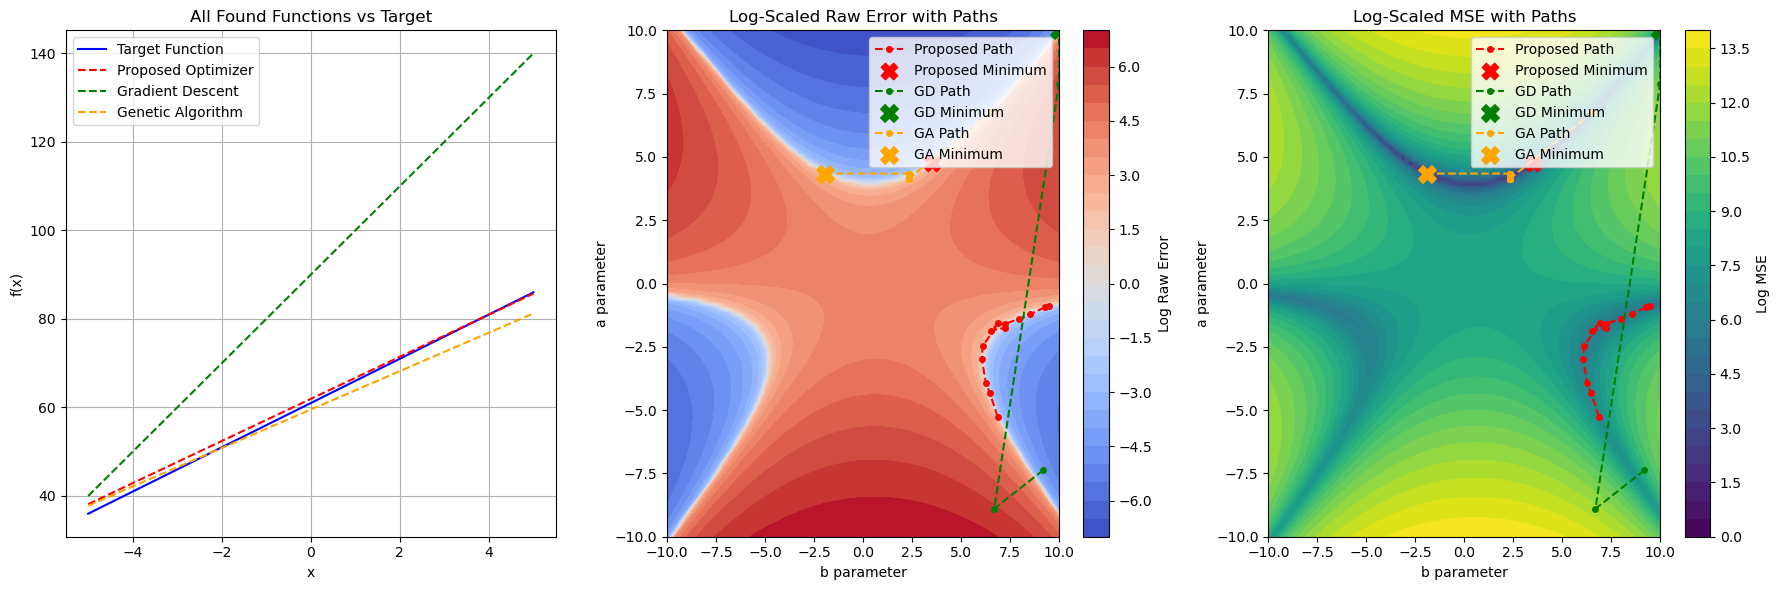

In [68]:
# Plotting results
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot all functions together
axs[0].plot(x_range_1D, true_values_1D, color='blue', label="Target Function")
axs[0].plot(x_range_1D, found_values_proposed, color='red', linestyle='--', label="Proposed Optimizer")
axs[0].plot(x_range_1D, found_values_gd, color='green', linestyle='--', label="Gradient Descent")
axs[0].plot(x_range_1D, found_values_ga, color='orange', linestyle='--', label="Genetic Algorithm")
axs[0].set_title("All Found Functions vs Target")
axs[0].set_xlabel("x")
axs[0].set_ylabel("f(x)")
axs[0].grid(True)
axs[0].legend()

# Raw error contour plot with paths and minima
cmap1 = axs[1].contourf(b_values, a_values, error_grid_log, levels=30, cmap="coolwarm")

# Proposed Optimizer
proposed_path_array = np.array(proposed_path)
axs[1].plot(proposed_path_array[:, 1], proposed_path_array[:, 0], color="red", linestyle="--", marker="o", markersize=4, label="Proposed Path")
axs[1].scatter(b_proposed_min, a_proposed_min, color="red", marker="X", s=140, label="Proposed Minimum")

# Gradient Descent
gd_path_array = np.array(gd_path)
axs[1].plot(gd_path_array[:, 1], gd_path_array[:, 0], color="green", linestyle="--", marker="o", markersize=4, label="GD Path")
axs[1].scatter(b_gd_min, a_gd_min, color="green", marker="X", s=160, label="GD Minimum")

# Genetic Algorithm
ga_path_array = np.array(ga_history)
axs[1].plot(ga_path_array[:, 1], ga_path_array[:, 0], color="orange", linestyle="--", marker="o", markersize=4, label="GA Path")
axs[1].scatter(b_ga_min, a_ga_min, color="orange", marker="X", s=160, label="GA Minimum")

axs[1].set_title("Log-Scaled Raw Error with Paths")
axs[1].set_xlabel("b parameter")
axs[1].set_ylabel("a parameter")
fig.colorbar(cmap1, ax=axs[1], label="Log Raw Error")
axs[1].legend(loc="upper right")

# MSE contour plot with paths and minima
cmap2 = axs[2].contourf(b_values, a_values, MSE_grid_log, levels=30, cmap="viridis")

# Proposed Optimizer Path
axs[2].plot(proposed_path_array[:, 1], proposed_path_array[:, 0], color="red", linestyle="--", marker="o", markersize=4, label="Proposed Path")
axs[2].scatter(b_proposed_min, a_proposed_min, color="red", marker="X", s=140, label="Proposed Minimum")

# Gradient Descent Path
axs[2].plot(gd_path_array[:, 1], gd_path_array[:, 0], color="green", linestyle="--", marker="o", markersize=4, label="GD Path")
axs[2].scatter(b_gd_min, a_gd_min, color="green", marker="X", s=160, label="GD Minimum")

# Genetic Algorithm Path
axs[2].plot(ga_path_array[:, 1], ga_path_array[:, 0], color="orange", linestyle="--", marker="o", markersize=4, label="GA Path")
axs[2].scatter(b_ga_min, a_ga_min, color="orange", marker="X", s=160, label="GA Minimum")

axs[2].set_title("Log-Scaled MSE with Paths")
axs[2].set_xlabel("b parameter")
axs[2].set_ylabel("a parameter")
fig.colorbar(cmap2, ax=axs[2], label="Log MSE")
axs[2].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [69]:
# 1. Setup Function for Optimization Landscape
def setup_optimization(model_func, limits, true_a, true_b, num_points=100, epsilon=1e-6):
    # Define the search space for parameters a and b
    a_values = np.linspace(-limits, limits, 100)
    b_values = np.linspace(-limits, limits, 100)

    # Initialize error and MSE grids
    error_grid = np.zeros((len(a_values), len(b_values)))
    MSE_grid = np.zeros((len(a_values), len(b_values)))

    # Generate sample points for function evaluation
    x_range_1D = np.linspace(-5, 5, num_points)

    # Create landscape
    true_values_1D, error_grid, MSE_grid, error_grid_log, MSE_grid_log = create_landscape(
        x_range_1D, true_a, true_b, a_values, b_values, model_func, epsilon
    )

    return a_values, b_values, error_grid, MSE_grid, error_grid_log, MSE_grid_log, x_range_1D, true_values_1D

# 2. Function to Run All Optimizers
def run_optimizers(error_grid, a_values, b_values, MSE_grid):
    a_proposed_min, b_proposed_min, proposed_path = proposed_optimizer(error_grid, a_values, b_values, MSE_grid)
    a_gd_min, b_gd_min, gd_path = gradient_descent_optimizer(MSE_grid, a_values, b_values)
    a_ga_min, b_ga_min, ga_history = genetic_algorithm_mse_grid(MSE_grid, a_values, b_values)
    
    return (a_proposed_min, b_proposed_min, proposed_path), (a_gd_min, b_gd_min, gd_path), (a_ga_min, b_ga_min, ga_history)

# 3. Generate Found Values for Each Optimizer
def generate_found_values(model_func, x_range_1D, optimizer_results):
    (a_proposed_min, b_proposed_min, _), (a_gd_min, b_gd_min, _), (a_ga_min, b_ga_min, _) = optimizer_results
    found_values_proposed = np.array([model_func(x, a_proposed_min, b_proposed_min) for x in x_range_1D])
    found_values_gd = np.array([model_func(x, a_gd_min, b_gd_min) for x in x_range_1D])
    found_values_ga = np.array([model_func(x, a_ga_min, b_ga_min) for x in x_range_1D])

    return found_values_proposed, found_values_gd, found_values_ga

# 4. Plotting Function for Results
def plot_optimization_results(x_range_1D, true_values_1D, found_values, optimizer_results, a_values, b_values, error_grid_log, MSE_grid_log):
    (a_proposed_min, b_proposed_min, proposed_path), (a_gd_min, b_gd_min, gd_path), (a_ga_min, b_ga_min, ga_history) = optimizer_results
    found_values_proposed, found_values_gd, found_values_ga = found_values

    # Plotting results
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Plot all functions together
    axs[0].plot(x_range_1D, true_values_1D, color='blue', label="Target Function")
    axs[0].plot(x_range_1D, found_values_proposed, color='red', linestyle='--', label="Proposed Optimizer")
    axs[0].plot(x_range_1D, found_values_gd, color='green', linestyle='--', label="Gradient Descent")
    axs[0].plot(x_range_1D, found_values_ga, color='orange', linestyle='--', label="Genetic Algorithm")
    axs[0].set_title("All Found Functions vs Target")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("f(x)")
    axs[0].grid(True)
    axs[0].legend()

    # Raw error contour plot with paths and minima
    cmap1 = axs[1].contourf(b_values, a_values, error_grid_log, levels=30, cmap="coolwarm")

    proposed_path_array = np.array(proposed_path)
    axs[1].plot(proposed_path_array[:, 1], proposed_path_array[:, 0], color="red", linestyle="--", marker="o", markersize=4, label="Proposed Path")
    axs[1].scatter(b_proposed_min, a_proposed_min, color="red", marker="X", s=140, label="Proposed Minimum")

    gd_path_array = np.array(gd_path)
    axs[1].plot(gd_path_array[:, 1], gd_path_array[:, 0], color="green", linestyle="--", marker="o", markersize=4, label="GD Path")
    axs[1].scatter(b_gd_min, a_gd_min, color="green", marker="X", s=160, label="GD Minimum")

    ga_path_array = np.array(ga_history)
    axs[1].plot(ga_path_array[:, 1], ga_path_array[:, 0], color="orange", linestyle="--", marker="o", markersize=4, label="GA Path")
    axs[1].scatter(b_ga_min, a_ga_min, color="orange", marker="X", s=160, label="GA Minimum")

    axs[1].set_title("Log-Scaled Raw Error with Paths")
    axs[1].set_xlabel("b parameter")
    axs[1].set_ylabel("a parameter")
    fig.colorbar(cmap1, ax=axs[1], label="Log Raw Error")
    axs[1].legend(loc="upper right")

    # MSE contour plot with paths and minima
    cmap2 = axs[2].contourf(b_values, a_values, MSE_grid_log, levels=30, cmap="viridis")

    axs[2].plot(proposed_path_array[:, 1], proposed_path_array[:, 0], color="red", linestyle="--", marker="o", markersize=4, label="Proposed Path")
    axs[2].scatter(b_proposed_min, a_proposed_min, color="red", marker="X", s=140, label="Proposed Minimum")

    axs[2].plot(gd_path_array[:, 1], gd_path_array[:, 0], color="green", linestyle="--", marker="o", markersize=4, label="GD Path")
    axs[2].scatter(b_gd_min, a_gd_min, color="green", marker="X", s=160, label="GD Minimum")

    axs[2].plot(ga_path_array[:, 1], ga_path_array[:, 0], color="orange", linestyle="--", marker="o", markersize=4, label="GA Path")
    axs[2].scatter(b_ga_min, a_ga_min, color="orange", marker="X", s=160, label="GA Minimum")

    axs[2].set_title("Log-Scaled MSE with Paths")
    axs[2].set_xlabel("b parameter")
    axs[2].set_ylabel("a parameter")
    fig.colorbar(cmap2, ax=axs[2], label="Log MSE")
    axs[2].legend(loc="upper right")

    plt.tight_layout()
    plt.show()

# 5. Complete Pipeline Function
def run_pipeline(model_func, limits, true_a, true_b):
    # Setup optimization landscape
    a_vals, b_vals, error_grid, MSE_grid, error_grid_log, MSE_grid_log, x_range_1D, true_values_1D = setup_optimization(
        model_func, limits, true_a, true_b
    )

    # Run optimizers
    optimizer_results = run_optimizers(error_grid, a_vals, b_vals, MSE_grid)

    # Generate found values from optimizers
    found_values = generate_found_values(model_func, x_range_1D, optimizer_results)

    # Plot the results
    plot_optimization_results(x_range_1D, true_values_1D, found_values, optimizer_results, a_vals, b_vals, error_grid_log, MSE_grid_log)


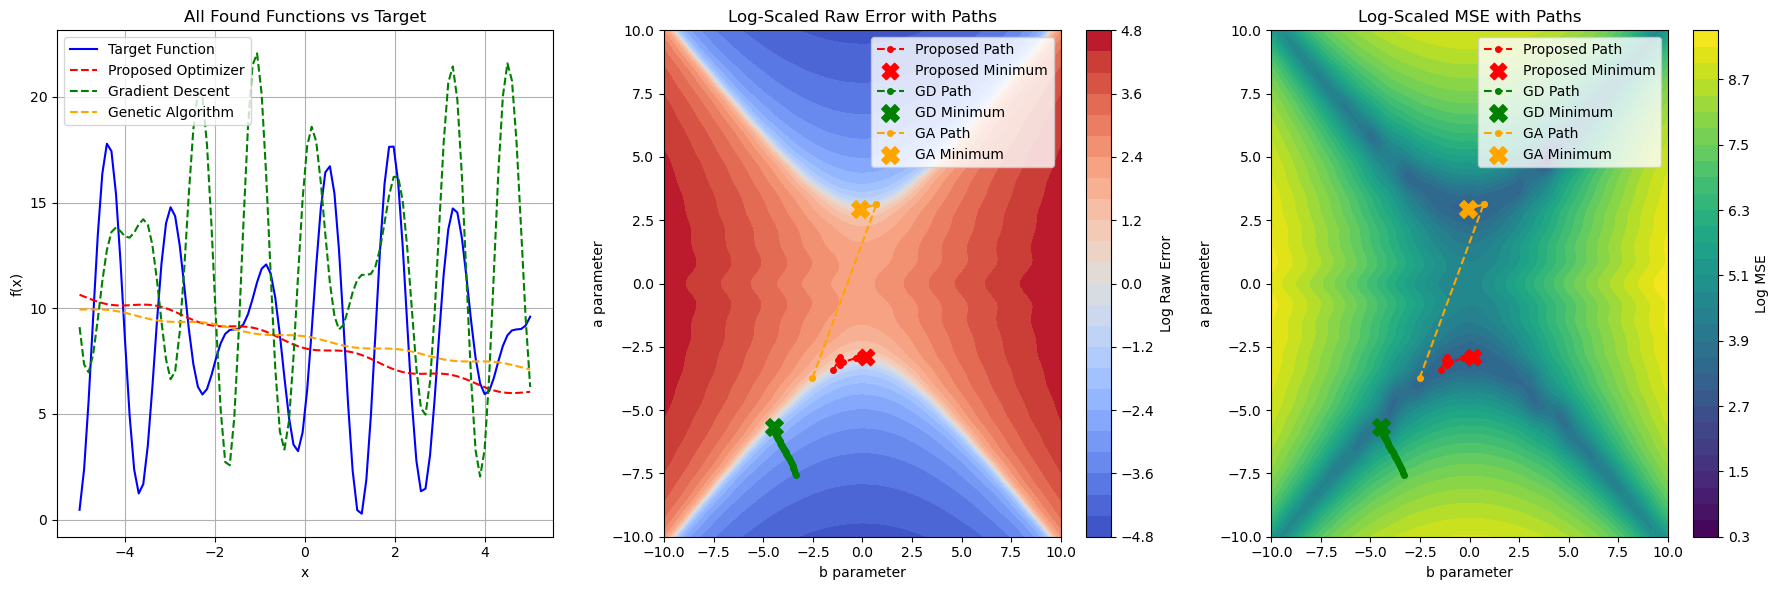

In [70]:
# Set parameters and run the pipeline
run_pipeline(model_sinusoidal, limits=10, true_a=5, true_b=4)

In [71]:
# 1. Function to Compute Optimization Results for a List of Functions
def compute_optimization_results(model_funcs, limits, true_a, true_b):
    results = {}

    for model_name, model_func in model_funcs.items():
        print(f"Running optimization for {model_name}...")

        # Setup landscape
        a_vals, b_vals, error_grid, MSE_grid, error_grid_log, MSE_grid_log, x_range_1D, true_values_1D = setup_optimization(
            model_func, limits, true_a, true_b
        )

        # Run optimizers
        optimizer_results = run_optimizers(error_grid, a_vals, b_vals, MSE_grid)

        # Generate found values from optimizers
        found_values = generate_found_values(model_func, x_range_1D, optimizer_results)

        # Store results in a dictionary
        results[model_name] = {
            "a_vals": a_vals,
            "b_vals": b_vals,
            "error_grid_log": error_grid_log,
            "MSE_grid_log": MSE_grid_log,
            "x_range_1D": x_range_1D,
            "true_values_1D": true_values_1D,
            "found_values": found_values,
            "optimizer_results": optimizer_results
        }

    return results


# 2. Function to Plot Optimization Results for All Functions
def plot_comparative_results(results):
    num_models = len(results)
    fig, axs = plt.subplots(num_models, 3, figsize=(18, 6 * num_models))

    if num_models == 1:
        axs = np.expand_dims(axs, axis=0)  # Ensure axs is always 2D for consistency

    for i, (model_name, data) in enumerate(results.items()):
        x_range_1D = data["x_range_1D"]
        true_values_1D = data["true_values_1D"]
        found_values = data["found_values"]
        optimizer_results = data["optimizer_results"]
        a_vals = data["a_vals"]
        b_vals = data["b_vals"]
        error_grid_log = data["error_grid_log"]
        MSE_grid_log = data["MSE_grid_log"]

        (a_proposed_min, b_proposed_min, proposed_path), (a_gd_min, b_gd_min, gd_path), (a_ga_min, b_ga_min, ga_history) = optimizer_results
        found_values_proposed, found_values_gd, found_values_ga = found_values

        # Plot all functions together
        axs[i, 0].plot(x_range_1D, true_values_1D, color='blue', label="Target Function")
        axs[i, 0].plot(x_range_1D, found_values_proposed, color='red', linestyle='--', label="Proposed Optimizer")
        axs[i, 0].plot(x_range_1D, found_values_gd, color='green', linestyle='--', label="Gradient Descent")
        axs[i, 0].plot(x_range_1D, found_values_ga, color='orange', linestyle='--', label="Genetic Algorithm")
        axs[i, 0].set_title(f"{model_name}: All Found Functions vs Target")
        axs[i, 0].set_xlabel("x")
        axs[i, 0].set_ylabel("f(x)")
        axs[i, 0].grid(True)
        axs[i, 0].legend()

        # Raw error contour plot
        cmap1 = axs[i, 1].contourf(b_vals, a_vals, error_grid_log, levels=30, cmap="coolwarm")
        proposed_path_array = np.array(proposed_path)
        axs[i, 1].plot(proposed_path_array[:, 1], proposed_path_array[:, 0], color="red", linestyle="--", marker="o", markersize=4, label="Proposed Path")
        axs[i, 1].scatter(b_proposed_min, a_proposed_min, color="red", marker="X", s=140, label="Proposed Minimum")
        gd_path_array = np.array(gd_path)
        axs[i, 1].plot(gd_path_array[:, 1], gd_path_array[:, 0], color="green", linestyle="--", marker="o", markersize=4, label="GD Path")
        axs[i, 1].scatter(b_gd_min, a_gd_min, color="green", marker="X", s=160, label="GD Minimum")
        ga_path_array = np.array(ga_history)
        axs[i, 1].plot(ga_path_array[:, 1], ga_path_array[:, 0], color="orange", linestyle="--", marker="o", markersize=4, label="GA Path")
        axs[i, 1].scatter(b_ga_min, a_ga_min, color="orange", marker="X", s=160, label="GA Minimum")
        axs[i, 1].set_title(f"{model_name}: Log-Scaled Raw Error with Paths")
        axs[i, 1].set_xlabel("b parameter")
        axs[i, 1].set_ylabel("a parameter")
        fig.colorbar(cmap1, ax=axs[i, 1], label="Log Raw Error")
        axs[i, 1].legend(loc="upper right")

        # MSE contour plot
        cmap2 = axs[i, 2].contourf(b_vals, a_vals, MSE_grid_log, levels=30, cmap="viridis")
        axs[i, 2].plot(proposed_path_array[:, 1], proposed_path_array[:, 0], color="red", linestyle="--", marker="o", markersize=4, label="Proposed Path")
        axs[i, 2].scatter(b_proposed_min, a_proposed_min, color="red", marker="X", s=140, label="Proposed Minimum")
        axs[i, 2].plot(gd_path_array[:, 1], gd_path_array[:, 0], color="green", linestyle="--", marker="o", markersize=4, label="GD Path")
        axs[i, 2].scatter(b_gd_min, a_gd_min, color="green", marker="X", s=160, label="GD Minimum")
        axs[i, 2].plot(ga_path_array[:, 1], ga_path_array[:, 0], color="orange", linestyle="--", marker="o", markersize=4, label="GA Path")
        axs[i, 2].scatter(b_ga_min, a_ga_min, color="orange", marker="X", s=160, label="GA Minimum")
        axs[i, 2].set_title(f"{model_name}: Log-Scaled MSE with Paths")
        axs[i, 2].set_xlabel("b parameter")
        axs[i, 2].set_ylabel("a parameter")
        fig.colorbar(cmap2, ax=axs[i, 2], label="Log MSE")
        axs[i, 2].legend(loc="upper right")

    plt.tight_layout()
    plt.show()


In [72]:
# Define your list of functions to optimize
model_functions = {
    "Model 1": model_1,
    "Quadratic Model": model_quadratic,
    "Sinusoidal Model": model_sinusoidal
}

Running optimization for Model 1...
Running optimization for Quadratic Model...
Running optimization for Sinusoidal Model...


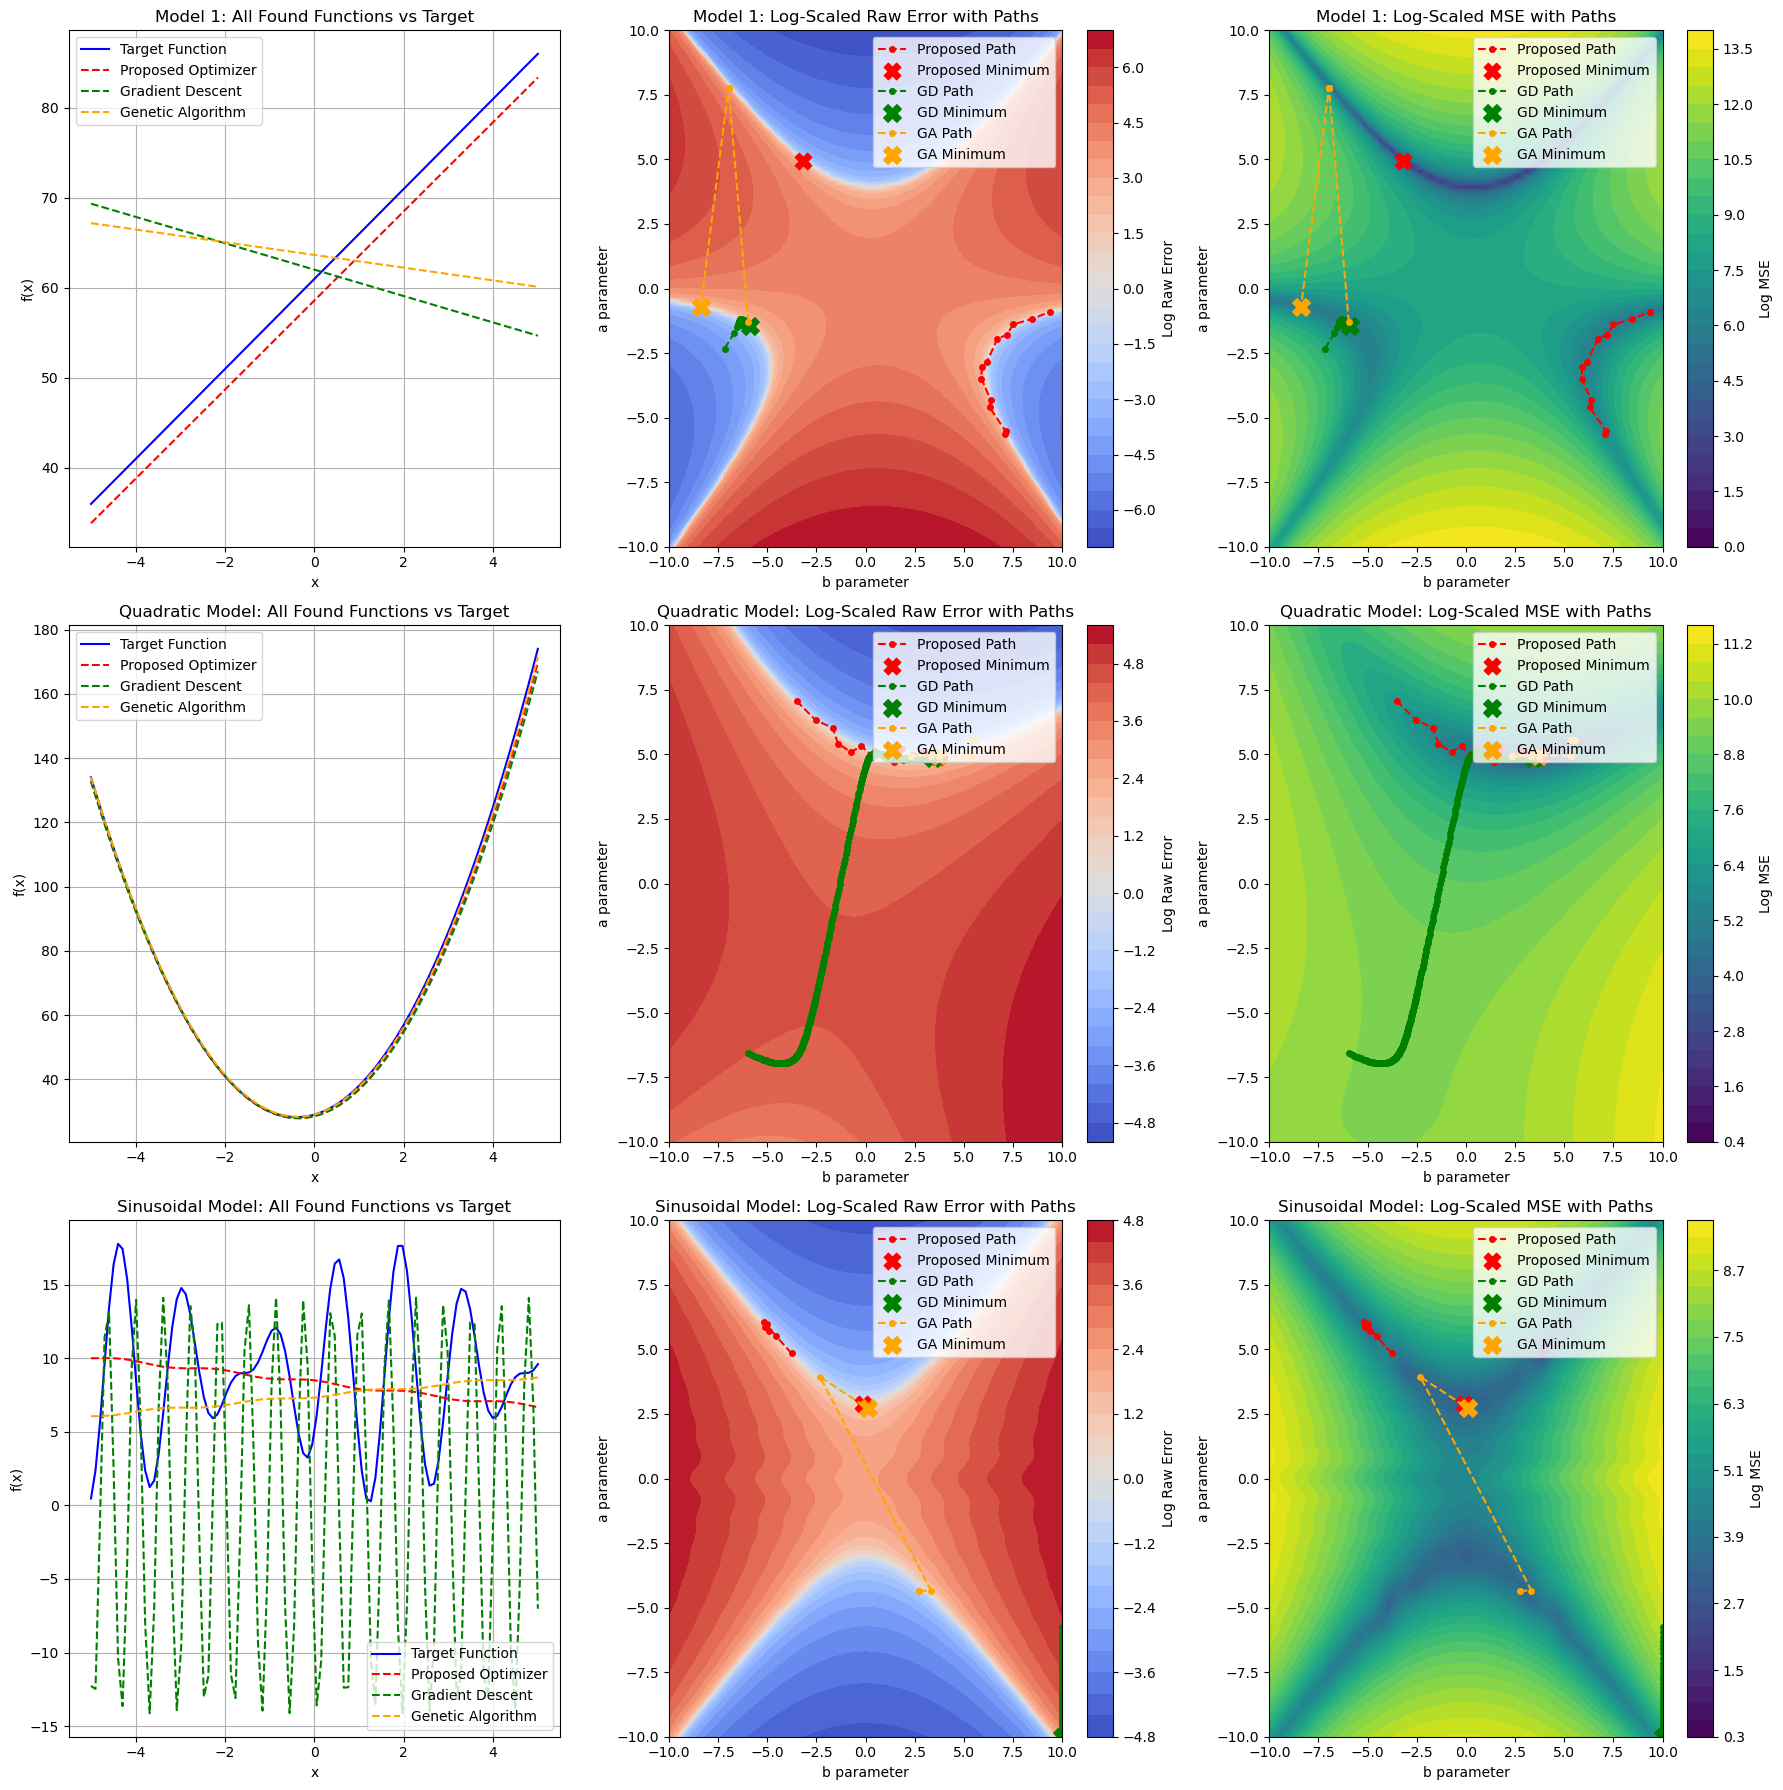

In [73]:
# Run optimization on multiple functions
results = compute_optimization_results(model_functions, limits=10, true_a=5, true_b=4)

# Plot the results for all models
plot_comparative_results(results)


In [74]:
import pandas as pd

# Function to generate a table with optimal values found
def generate_results_table(results):
    # List to store data for the DataFrame
    data = []

    # Loop through each model and extract the results
    for model_name, data_dict in results.items():
        a_vals = data_dict["a_vals"]
        b_vals = data_dict["b_vals"]
        MSE_grid = np.exp(data_dict["MSE_grid_log"])  # Convert log MSE back to original scale
        optimizer_results = data_dict["optimizer_results"]

        # Unpack results for each optimizer
        optimizers = ["Proposed Optimizer", "Gradient Descent", "Genetic Algorithm"]
        for optimizer_name, (a_min, b_min, _) in zip(optimizers, optimizer_results):
            # Find MSE at the final point
            idx_a = (np.abs(a_vals - a_min)).argmin()
            idx_b = (np.abs(b_vals - b_min)).argmin()
            final_mse = MSE_grid[idx_a, idx_b]

            # Append the result
            data.append({
                "Model": model_name,
                "Optimizer": optimizer_name,
                "Optimal a": round(a_min, 5),
                "Optimal b": round(b_min, 5),
                "Final MSE": round(final_mse, 5)
            })

    # Create a DataFrame from the results
    results_df = pd.DataFrame(data)

    return results_df


In [75]:
# Run optimization on multiple functions
results = compute_optimization_results(model_functions, limits=10, true_a=5, true_b=4)

# Generate and display the table of results
results_table = generate_results_table(results)


Running optimization for Model 1...
Running optimization for Quadratic Model...
Running optimization for Sinusoidal Model...


In [76]:
results_table

,Model,Optimizer,Optimal a,Optimal b,Final MSE
0,Model 1,Proposed Optimizer,4.93010,-3.03970,1.44062
1,Model 1,Gradient Descent,-1.42646,-5.85784,361.92539
2,Model 1,Genetic Algorithm,4.14141,1.91919,7.91617
3,Quadratic Model,Proposed Optimizer,5.04472,3.79371,1.89522
4,Quadratic Model,Gradient Descent,4.85031,3.43290,5.13330
5,Quadratic Model,Genetic Algorithm,4.94949,3.93939,2.08630
6,Sinusoidal Model,Proposed Optimizer,2.89403,-0.16761,22.13019
7,Sinusoidal Model,Gradient Descent,2.82830,0.60647,26.63955
8,Sinusoidal Model,Genetic Algorithm,2.92929,-0.10101,22.13019


In [77]:
def generate_pivot_results_table(results):
    # Dictionary to store data in a pivot-friendly format
    data = {}

    # Loop through each model and extract the results
    for model_name, data_dict in results.items():
        a_vals = data_dict["a_vals"]
        b_vals = data_dict["b_vals"]
        MSE_grid = np.exp(data_dict["MSE_grid_log"])  # Convert log MSE back to original scale
        optimizer_results = data_dict["optimizer_results"]

        # Unpack results for each optimizer
        optimizers = ["Proposed Optimizer", "Gradient Descent", "Genetic Algorithm"]
        for optimizer_name, (a_min, b_min, _) in zip(optimizers, optimizer_results):
            # Find MSE at the final point
            idx_a = (np.abs(a_vals - a_min)).argmin()
            idx_b = (np.abs(b_vals - b_min)).argmin()
            final_mse = MSE_grid[idx_a, idx_b]

            # Add to data dictionary
            if optimizer_name not in data:
                data[optimizer_name] = {}
            data[optimizer_name][model_name] = (round(a_min, 5), round(b_min, 5), round(final_mse, 5))

    # Create a DataFrame from the dictionary
    results_df = pd.DataFrame(data).transpose()  # Optimizers as rows, Models as columns

    return results_df


In [78]:
# Run optimization on multiple functions
results = compute_optimization_results(model_functions, limits=10, true_a=5, true_b=4)

# Generate and display the pivot table
pivot_results_table = generate_pivot_results_table(results)


Running optimization for Model 1...
Running optimization for Quadratic Model...
Running optimization for Sinusoidal Model...


In [79]:
pivot_results_table

,Model 1,Quadratic Model,Sinusoidal Model
Proposed Optimizer,"(4.83538, 3.59417, 1.54984)","(4.94245, 3.79126, 1.89522)","(2.87794, -0.09345, 22.13019)"
Gradient Descent,"(3.86618, 0.20192, 10.71667)","(4.83898, 3.4336, 23.63239)","(-3.43463, -1.41375, 31.28704)"
Genetic Algorithm,"(5.15152, -3.53535, 12.43762)","(5.15152, 4.74747, 7.63123)","(-2.92929, 0.10101, 22.19123)"


In [80]:
def generate_mse_results_table(results):
    # Dictionary to store MSE values
    data = {}

    # Loop through each model and extract only the MSE results
    for model_name, data_dict in results.items():
        a_vals = data_dict["a_vals"]
        b_vals = data_dict["b_vals"]
        MSE_grid = np.exp(data_dict["MSE_grid_log"])  # Convert log MSE back to original scale
        optimizer_results = data_dict["optimizer_results"]

        # Unpack results for each optimizer
        optimizers = ["Proposed Optimizer", "Gradient Descent", "Genetic Algorithm"]
        for optimizer_name, (a_min, b_min, _) in zip(optimizers, optimizer_results):
            # Find MSE at the final point
            idx_a = (np.abs(a_vals - a_min)).argmin()
            idx_b = (np.abs(b_vals - b_min)).argmin()
            final_mse = MSE_grid[idx_a, idx_b]

            # Add MSE to data dictionary
            if optimizer_name not in data:
                data[optimizer_name] = {}
            data[optimizer_name][model_name] = round(final_mse, 5)

    # Create a DataFrame from the dictionary
    results_df = pd.DataFrame(data).transpose()  # Optimizers as rows, Models as columns

    return results_df


In [83]:
# Run optimization on multiple functions
results = compute_optimization_results(model_functions, limits=10, true_a=5, true_b=4)

# Generate and display the simplified MSE-only table
mse_results_table = generate_mse_results_table(results)


Running optimization for Model 1...
Running optimization for Quadratic Model...
Running optimization for Sinusoidal Model...


In [84]:
mse_results_table

,Model 1,Quadratic Model,Sinusoidal Model
Proposed Optimizer,1.54984,1.89522,22.19123
Gradient Descent,83.61286,5.13330,28.18387
Genetic Algorithm,10.60436,7.35622,4.67947


In [85]:
def compute_optimization_results_multiple_runs(model_funcs, limits, true_a, true_b, n_runs=10):
    # Store MSE results for each run
    mse_results = {model_name: {optimizer: [] for optimizer in ["Proposed Optimizer", "Gradient Descent", "Genetic Algorithm"]}
                   for model_name in model_funcs.keys()}

    for run in range(n_runs):
        print(f"Running simulation {run + 1}/{n_runs}...")
        # Loop through each model
        for model_name, model_func in model_funcs.items():
            # Setup landscape
            a_vals, b_vals, error_grid, MSE_grid, error_grid_log, MSE_grid_log, x_range_1D, true_values_1D = setup_optimization(
                model_func, limits, true_a, true_b
            )

            # Run optimizers
            optimizer_results = run_optimizers(error_grid, a_vals, b_vals, MSE_grid)

            # Extract final MSE for each optimizer
            for optimizer_name, (a_min, b_min, _) in zip(["Proposed Optimizer", "Gradient Descent", "Genetic Algorithm"], optimizer_results):
                idx_a = (np.abs(a_vals - a_min)).argmin()
                idx_b = (np.abs(b_vals - b_min)).argmin()
                final_mse = np.exp(MSE_grid_log[idx_a, idx_b])  # Convert log MSE back to original scale
                mse_results[model_name][optimizer_name].append(final_mse)

    return mse_results


In [86]:
def generate_mean_mse_results_table(mse_results):
    # Prepare data for DataFrame
    data = {}

    for model_name, optimizer_data in mse_results.items():
        for optimizer_name, mse_list in optimizer_data.items():
            mean_mse = round(np.mean(mse_list), 5)  # Compute mean MSE
            if optimizer_name not in data:
                data[optimizer_name] = {}
            data[optimizer_name][model_name] = mean_mse

    # Create a DataFrame from the results
    results_df = pd.DataFrame(data).transpose()  # Optimizers as rows, Models as columns

    return results_df


In [88]:
# Define your models
model_functions = {
    "Linear Model": model_1,
    "Quadratic Model": model_quadratic,
    "Sinusoidal Model": model_sinusoidal
}

# Run optimization n times for each model
n_runs = 2  # Number of simulations
mse_results = compute_optimization_results_multiple_runs(model_functions, limits=10, true_a=5, true_b=4, n_runs=n_runs)

# Generate and display the mean MSE table
mean_mse_results_table = generate_mean_mse_results_table(mse_results)

Running simulation 1/2...
Running simulation 2/2...


In [89]:
mean_mse_results_table

,Linear Model,Quadratic Model,Sinusoidal Model
Proposed Optimizer,1.44062,1.89522,22.16071
Gradient Descent,250.93830,250.92268,54.86323
Genetic Algorithm,7.74969,1.89522,22.13019
